In [166]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [136]:
path = 'customer_segmentation.csv'
df = pd.read_csv(path)

In [137]:
print("First few rows of the DataFrame:")
print(df.head())

First few rows of the DataFrame:
     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  Accepted

In [138]:
print("\nMissing values check:")
print(df.isnull().sum())


Missing values check:
ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64


In [139]:
print("\nDuplicate rows check:")
print(df.duplicated().sum())


Duplicate rows check:
0


In [140]:
# Function to print numerical and non-numerical columns along with their record count
def print_column_info(df):
    print("Numerical columns:")
    numerical_cols = df.select_dtypes(include=['number']).columns
    for col in numerical_cols:
        print(f"{col}: {df[col].count()} records")
    
    print("\nNon-numerical columns:")
    non_numerical_cols = df.select_dtypes(exclude=['number']).columns
    for col in non_numerical_cols:
        print(f"{col}: {df[col].count()} records")

print_column_info(df)

Numerical columns:
ID: 2240 records
Year_Birth: 2240 records
Income: 2216 records
Kidhome: 2240 records
Teenhome: 2240 records
Recency: 2240 records
MntWines: 2240 records
MntFruits: 2240 records
MntMeatProducts: 2240 records
MntFishProducts: 2240 records
MntSweetProducts: 2240 records
MntGoldProds: 2240 records
NumDealsPurchases: 2240 records
NumWebPurchases: 2240 records
NumCatalogPurchases: 2240 records
NumStorePurchases: 2240 records
NumWebVisitsMonth: 2240 records
AcceptedCmp3: 2240 records
AcceptedCmp4: 2240 records
AcceptedCmp5: 2240 records
AcceptedCmp1: 2240 records
AcceptedCmp2: 2240 records
Complain: 2240 records
Z_CostContact: 2240 records
Z_Revenue: 2240 records
Response: 2240 records

Non-numerical columns:
Education: 2240 records
Marital_Status: 2240 records
Dt_Customer: 2240 records


In [141]:
# Check unique categories and print if less than 10
print("\nUnique categories in non-numerical columns:")
non_numerical_cols = df.select_dtypes(exclude=['number']).columns
for col in non_numerical_cols:
    unique_categories = df[col].nunique()
    print(f"{col}: {unique_categories} unique categories")
    if unique_categories <= 10:
        print("Unique categories:")
        print(df[col].unique())


Unique categories in non-numerical columns:
Education: 5 unique categories
Unique categories:
['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']
Marital_Status: 8 unique categories
Unique categories:
['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']
Dt_Customer: 663 unique categories


In [142]:
# Summary statistics for numerical columns
print("\nSummary statistics for numerical columns:")
print(df.describe())


Summary statistics for numerical columns:
                 ID   Year_Birth         Income      Kidhome     Teenhome  \
count   2240.000000  2240.000000    2216.000000  2240.000000  2240.000000   
mean    5592.159821  1968.805804   52247.251354     0.444196     0.506250   
std     3246.662198    11.984069   25173.076661     0.538398     0.544538   
min        0.000000  1893.000000    1730.000000     0.000000     0.000000   
25%     2828.250000  1959.000000   35303.000000     0.000000     0.000000   
50%     5458.500000  1970.000000   51381.500000     0.000000     0.000000   
75%     8427.750000  1977.000000   68522.000000     1.000000     1.000000   
max    11191.000000  1996.000000  666666.000000     2.000000     2.000000   

           Recency     MntWines    MntFruits  MntMeatProducts  \
count  2240.000000  2240.000000  2240.000000      2240.000000   
mean     49.109375   303.935714    26.302232       166.950000   
std      28.962453   336.597393    39.773434       225.715373   
min

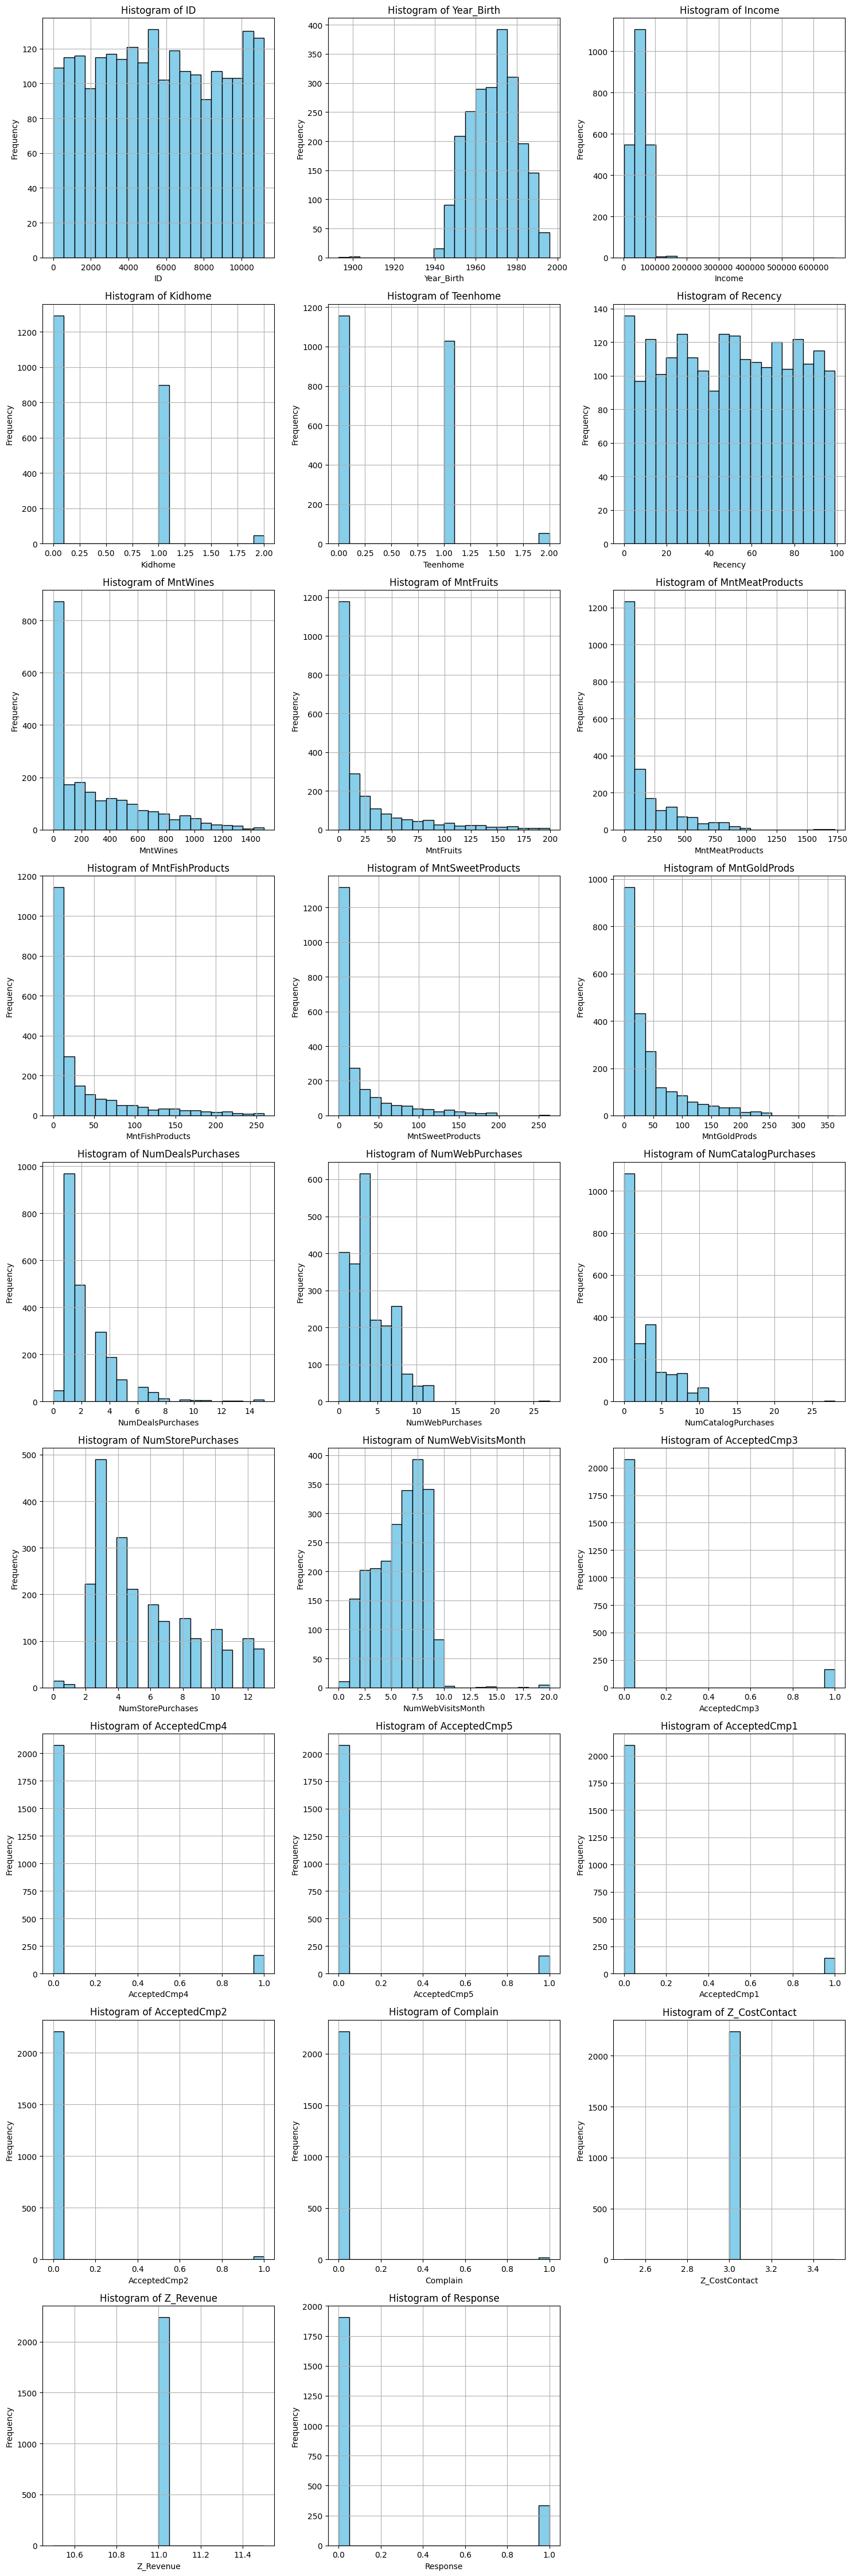

In [143]:
# Select numerical columns
numerical_cols = df.select_dtypes(include=['number']).columns

# Determine the number of rows and columns for subplots
num_cols = len(numerical_cols)
num_rows = (num_cols // 3) + (1 if num_cols % 3 != 0 else 0)  # 3 plots per row

# Create subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))

# Plot histograms for numerical columns
for i, col in enumerate(numerical_cols):
    row_idx = i // 3
    col_idx = i % 3
    ax = axes[row_idx, col_idx] if num_rows > 1 else axes[col_idx]
    df[col].hist(ax=ax, bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'Histogram of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

# Hide empty subplots
for i in range(num_cols, num_rows * 3):
    row_idx = i // 3
    col_idx = i % 3
    if num_rows > 1:
        axes[row_idx, col_idx].axis('off')
    else:
        axes[col_idx].axis('off')

plt.tight_layout()
plt.show()

In [144]:
# # Function to detect and handle outliers using IQR method
# def handle_outliers(df, col):
#     q1 = df[col].quantile(0.25)
#     q3 = df[col].quantile(0.75)
#     iqr = q3 - q1
#     lower_bound = q1 - 1.5 * iqr
#     upper_bound = q3 + 1.5 * iqr
    
#     # Detect outliers
#     outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    
#     # Replace outliers with median
#     median = df[col].median()
#     df[col] = np.where((df[col] < lower_bound) | (df[col] > upper_bound), median, df[col])
    
#     return outliers

# # Detect and handle outliers for each numerical column
# outliers_dict = {}
# for col in numerical_cols:
#     outliers = handle_outliers(df, col)
#     outliers_dict[col] = outliers

# # Print outliers for each numerical column
# for col, outliers in outliers_dict.items():
#     print(f"Outliers in {col}:")
#     print(outliers)

# # Print summary statistics after handling outliers
# print("\nSummary statistics after handling outliers:")
# print(df.describe())
# print(df.shape)

In [145]:
mean_income = df['Income'].mean()
print("Mean Income: " + str(mean_income))
df['Income'].fillna(mean_income, inplace=True)

Mean Income: 52247.25135379061


C:\Users\abdul\AppData\Local\Temp\ipykernel_18548\1471172899.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Income'].fillna(mean_income, inplace=True)


In [146]:
null_values = df.isnull().sum()
print(null_values)

ID                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Z_CostContact          0
Z_Revenue              0
Response               0
dtype: int64


In [147]:
to_drop = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response']
df.drop(columns=to_drop, inplace=True)
# df.head()


In [148]:
df_operate = df.copy()
df_operate.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5


In [149]:
numerical_cols = df_operate.select_dtypes(include=['number']).columns.tolist()

scaler = RobustScaler()
df_operate[numerical_cols] = scaler.fit_transform(df_operate[numerical_cols])


quartile_1, quartile_3 = df_operate[numerical_cols].quantile(0.25), df_operate[numerical_cols].quantile(0.75)
iqr = quartile_3 - quartile_1

# Define the outlier range 1.5 multiplier was too aggressive 
lower_bound = quartile_1 - (2 * iqr)
upper_bound = quartile_3 + (2 * iqr)

# Identify and remove outliers
for col in numerical_cols:
    outlier_mask = (df_operate[col] < lower_bound[col]) | (df_operate[col] > upper_bound[col])
    df_operate = df_operate.loc[~outlier_mask, :]




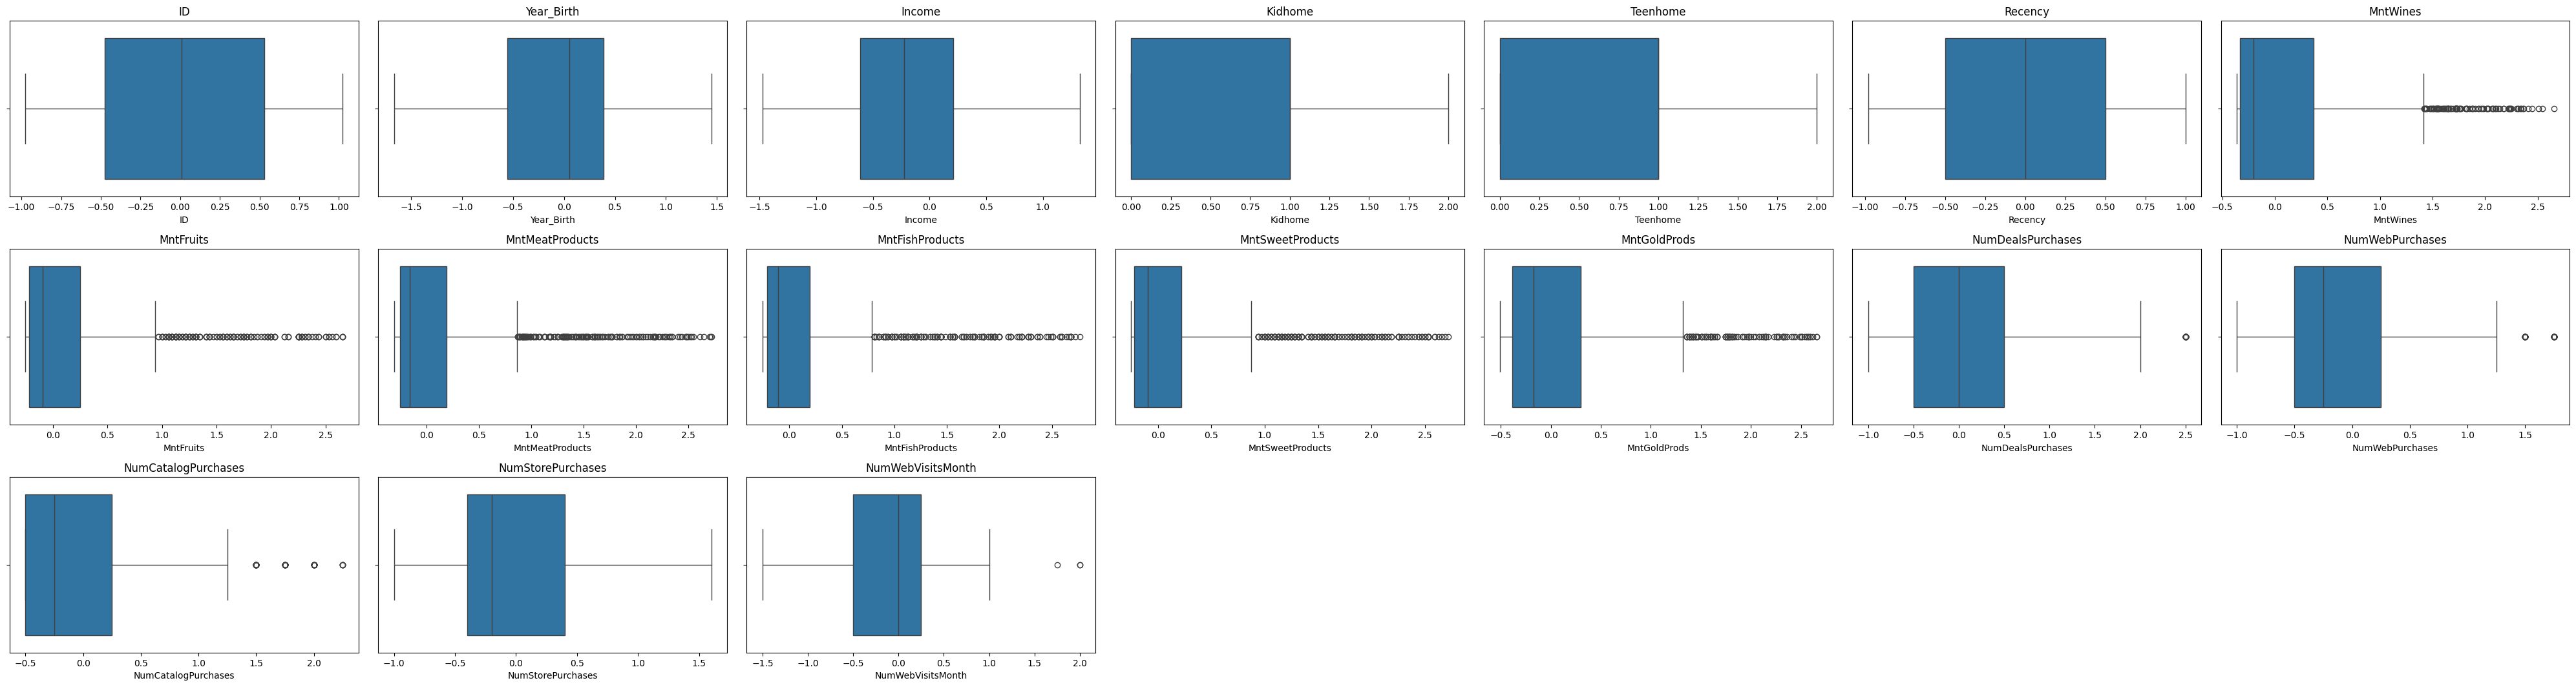

In [150]:
def visualize_outliers(data, numerical_features, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(40, 35))

    # Flatten the axes array for ease of indexing
    axes = axes.flatten()

    for i, feature in enumerate(numerical_features):
        sns.boxplot(x=data[feature], ax=axes[i])
        #axes[i].set_title(f'Box Plot for {feature}')
        axes[i].set_title(f'{feature}')

    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Specify the number of rows and columns for the grid
rows = 10  # You can adjust this based on the number of features
cols = 7

# Visualize outliers in the training set
visualize_outliers(df_operate, numerical_cols, rows, cols)

In [151]:
print("\nMissing values check:")
print(df_operate.isnull().sum())

print(df_operate.shape)


Missing values check:
ID                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
dtype: int64
(1697, 20)


In [152]:
# Extract date features
df_operate['dates'] = pd.to_datetime(df_operate['Dt_Customer'], format='%d-%m-%Y')

df_operate['year'] = df_operate['dates'].dt.year
df_operate['month'] = df_operate['dates'].dt.month
df_operate['day'] = df_operate['dates'].dt.day
df_operate.drop(columns=['Dt_Customer', 'dates'], inplace=True)

df_operate.head()

# df_encoded = df_operate.copy()


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,...,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,year,month,day
1,-0.586570,-0.888889,Graduation,Single,-0.164804,1.0,1.0,-0.22,-0.338189,-0.21875,...,-0.21875,-0.382979,0.0,-0.75,-0.25,-0.6,-0.25,2014,3,8
2,-0.235289,-0.277778,Graduation,Together,0.606745,0.0,0.0,-0.46,0.525494,1.28125,...,0.40625,0.382979,-0.5,1.00,0.00,1.0,-0.50,2013,8,21
3,0.129208,0.777778,Graduation,Together,-0.766251,1.0,0.0,-0.46,-0.338189,-0.12500,...,-0.15625,-0.404255,0.0,-0.50,-0.50,-0.2,0.00,2014,2,10
4,-0.024020,0.611111,PhD,Married,0.200040,1.0,0.0,0.90,-0.001041,1.09375,...,0.59375,-0.191489,1.5,0.25,0.25,0.2,-0.25,2014,1,19
5,0.354942,-0.166667,Master,Together,0.328891,0.0,1.0,-0.66,0.721124,1.06250,...,1.06250,-0.212766,0.0,0.50,0.50,1.0,0.00,2013,9,9


In [159]:

# One-hot encode non-numeric columns (excluding date-related columns)
categorical_columns = df_operate.select_dtypes(include=['object']).columns

df_encoded = pd.get_dummies(df_operate, columns=categorical_columns, drop_first=True)
print(categorical_columns)
print(df_encoded.shape)


Index(['Education', 'Marital_Status'], dtype='object')
(1697, 30)


In [160]:
#apply PCA on the data

pca = PCA(n_components=10)
df_pca = pca.fit_transform(df_encoded)

In [161]:
print(df_operate.columns)
print(df_encoded.columns)
print(df_operate.shape)
print(df_encoded.shape)

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'year', 'month', 'day'],
      dtype='object')
Index(['ID', 'Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Recency',
       'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
       'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'year', 'month', 'day', 'Education_Basic',
       'Education_Graduation', 'Education_Master', 'Education_PhD',
       'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Together',
       'Marital_Status_Widow', 'Marital_Status_YOLO'],
      dtype='object')
(1697, 22

In [162]:
print(df_pca.shape)
print(pca.explained_variance_ratio_)

(1697, 10)
[0.79400376 0.12637096 0.02379144 0.00844987 0.00602634 0.00389324
 0.00354473 0.00342248 0.00339351 0.0032348 ]


In [164]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

KMEANS

In [ ]:
#Select data for analysis
data = 

In [167]:
#KMEANS
#finding the number of clusters for PCA Using Elbow method.


wcss = []
silhouette_scores = []

for k in range(2, 11):  # Trying k from 2 to 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)  # Within-cluster sum of squares
    silhouette_scores.append(silhouette_score(data, kmeans.labels_))


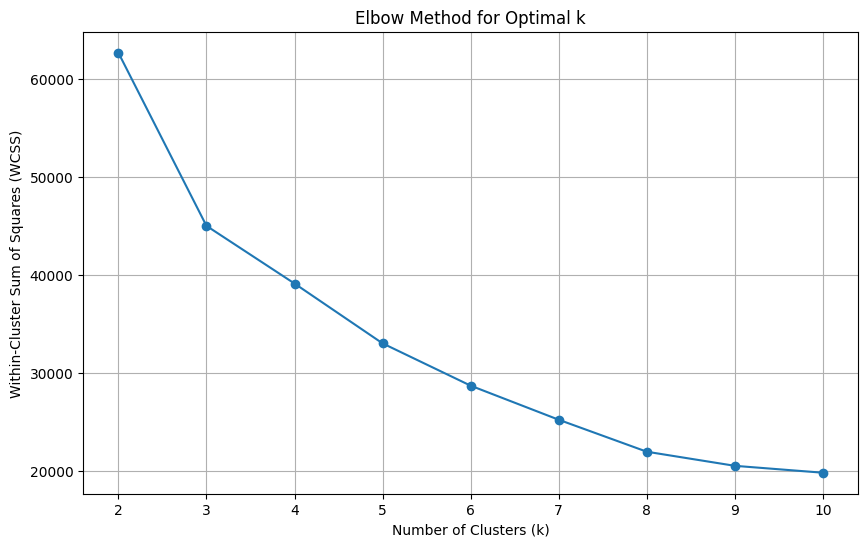

In [169]:
# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()

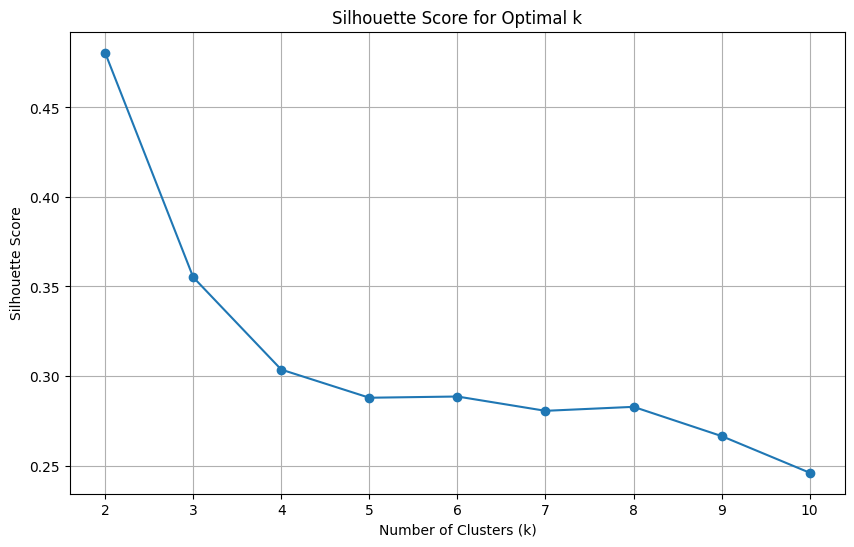

In [170]:
# Plot the Silhouette Score graph
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()

Test